# Instrumental folder generation for CMWP

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.xrd_tools import getReflections
from lmfit.models import LinearModel,  PseudoVoigtModel, Pearson7Model #, SkewedVoigtModel, SkewedGaussianModel
from scipy.interpolate import CubicSpline

## Set paramaters

In [2]:
a = 4.15691                  # a lattice paramater in angstrom             
wavelength = 1.540598         # Wavelength in angstrom

inputfile = '/home/rhys/Documents/CMWP-201225/BOR60/NI/LaB6.dat'
outfolder = '/home/rhys/Desktop/test'

In [3]:
peak_name, peak_pos = getReflections(crystalType='cubic',outputType='2theta', a=a, wavelength=wavelength, printReflections=False)
_, peak_pos_k = getReflections(crystalType='cubic', outputType='k', a=a, wavelength=wavelength, printReflections=False)
peak_pos_k_nm = peak_pos_k*10

In [4]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)

x_2theta, y = np.loadtxt(inputfile, unpack=True)

x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(x_2theta)/2)) / wavelength

## Plot data

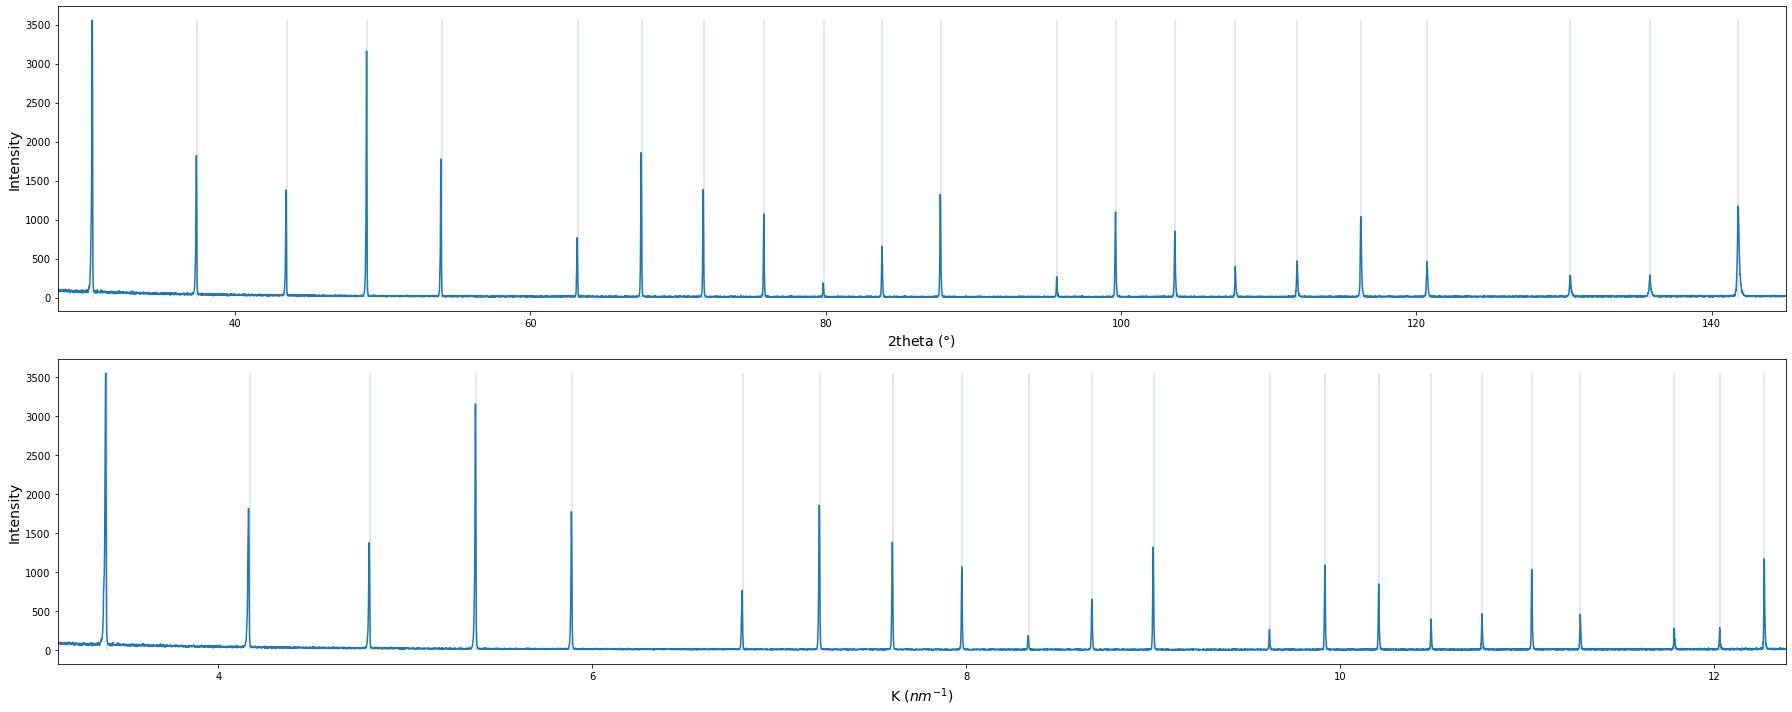

In [5]:
fig, (ax2, ax) = plt.subplots(2, 1, figsize=(25,10))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))

ax2.vlines(peak_pos, alpha=0.2, ymin=0, ymax=np.max(y))
ax2.plot(x_2theta, y, '-')
ax2.set_xlabel('2theta ($\degree$)', fontsize=14); ax2.set_ylabel('Intensity', fontsize=14);
ax2.set_xlim(np.min(x_2theta), np.max(x_2theta))
plt.tight_layout()

In [6]:
## Subtract background

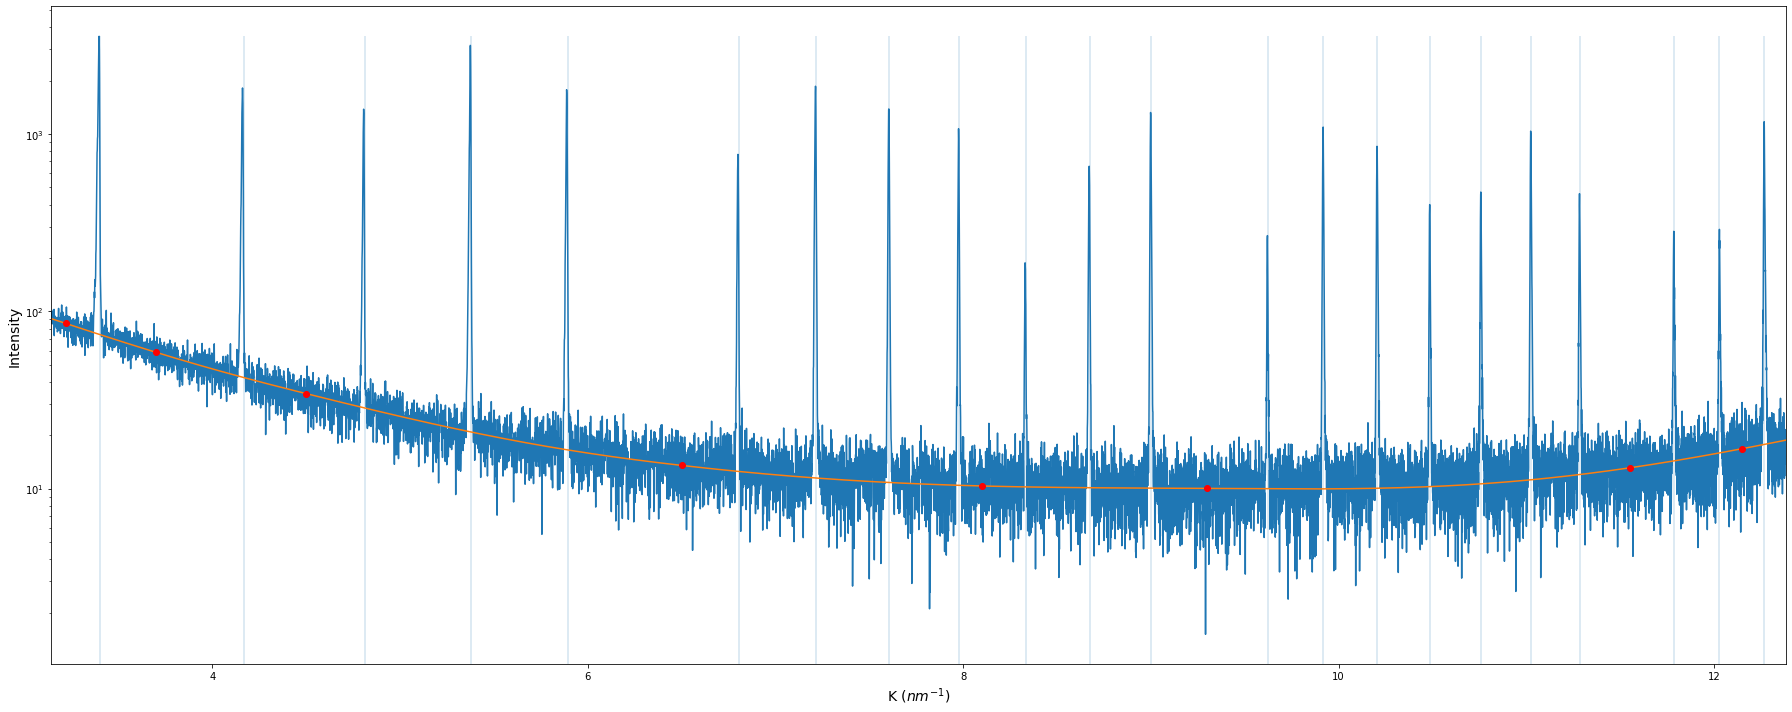

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(25,10))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.2)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')


plt.tight_layout()

baseline = [3.22, 3.7, 4.5, 6.5, 8.1, 9.3, 11.55, 12.15]
baseline_int=[]

for j in baseline:
    num_index =np.argmin(np.abs(x_k_nm-j))
    baseline_int.append(np.mean(y[num_index-10:num_index+10]))
        
cs = CubicSpline(baseline, baseline_int)

ax.plot(x_k_nm, cs(x_k_nm))
ax.plot(baseline, baseline_int, c='r', marker='o', linewidth=0)

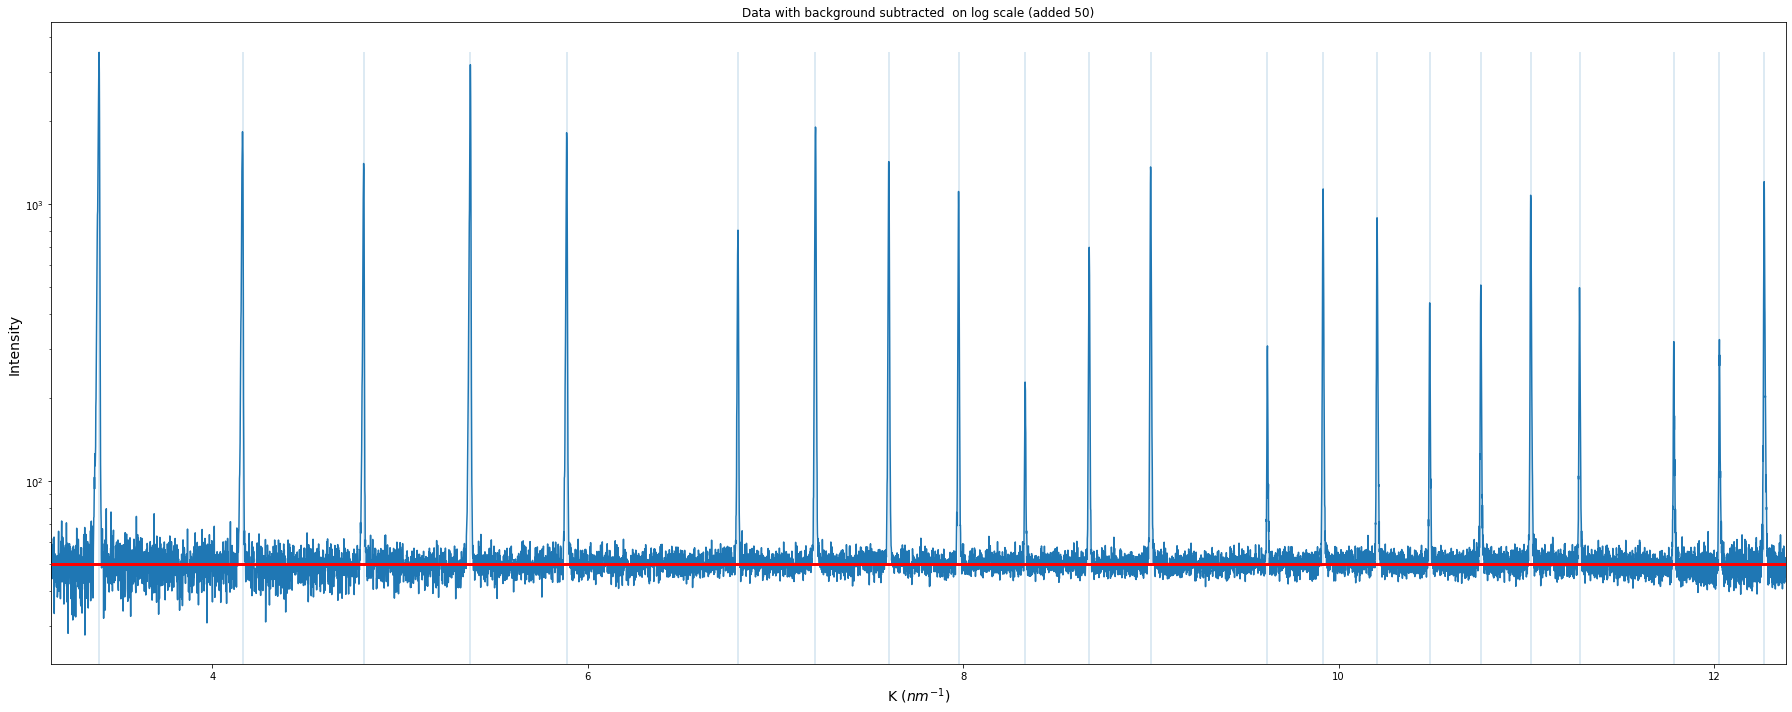

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(25,10))

y_nobck = y-cs(x_k_nm)

ax.plot(x_k_nm, y_nobck+50, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')
ax.hlines([50], colors='r', linewidth=3, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)
plt.title('Data with background subtracted  on log scale (added 50)')

actual_peaks = []


for i, peak in enumerate(peak_pos_k_nm):
    if np.min(x_k_nm) < peak < np.max(x_k_nm):
        
        searchrange = 10
        
        elem = np.abs(x_k_nm-peak).argmin()
                 

        peak_index = np.argmax(y_nobck[elem-searchrange:elem+searchrange])+elem-searchrange
        peak_x = x_k_nm[peak_index]
        actual_peaks.append(peak_x)
        
ax.vlines(actual_peaks, ymin=0, ymax=np.max(y), alpha=0.2)


plt.tight_layout()


## Fit peaks

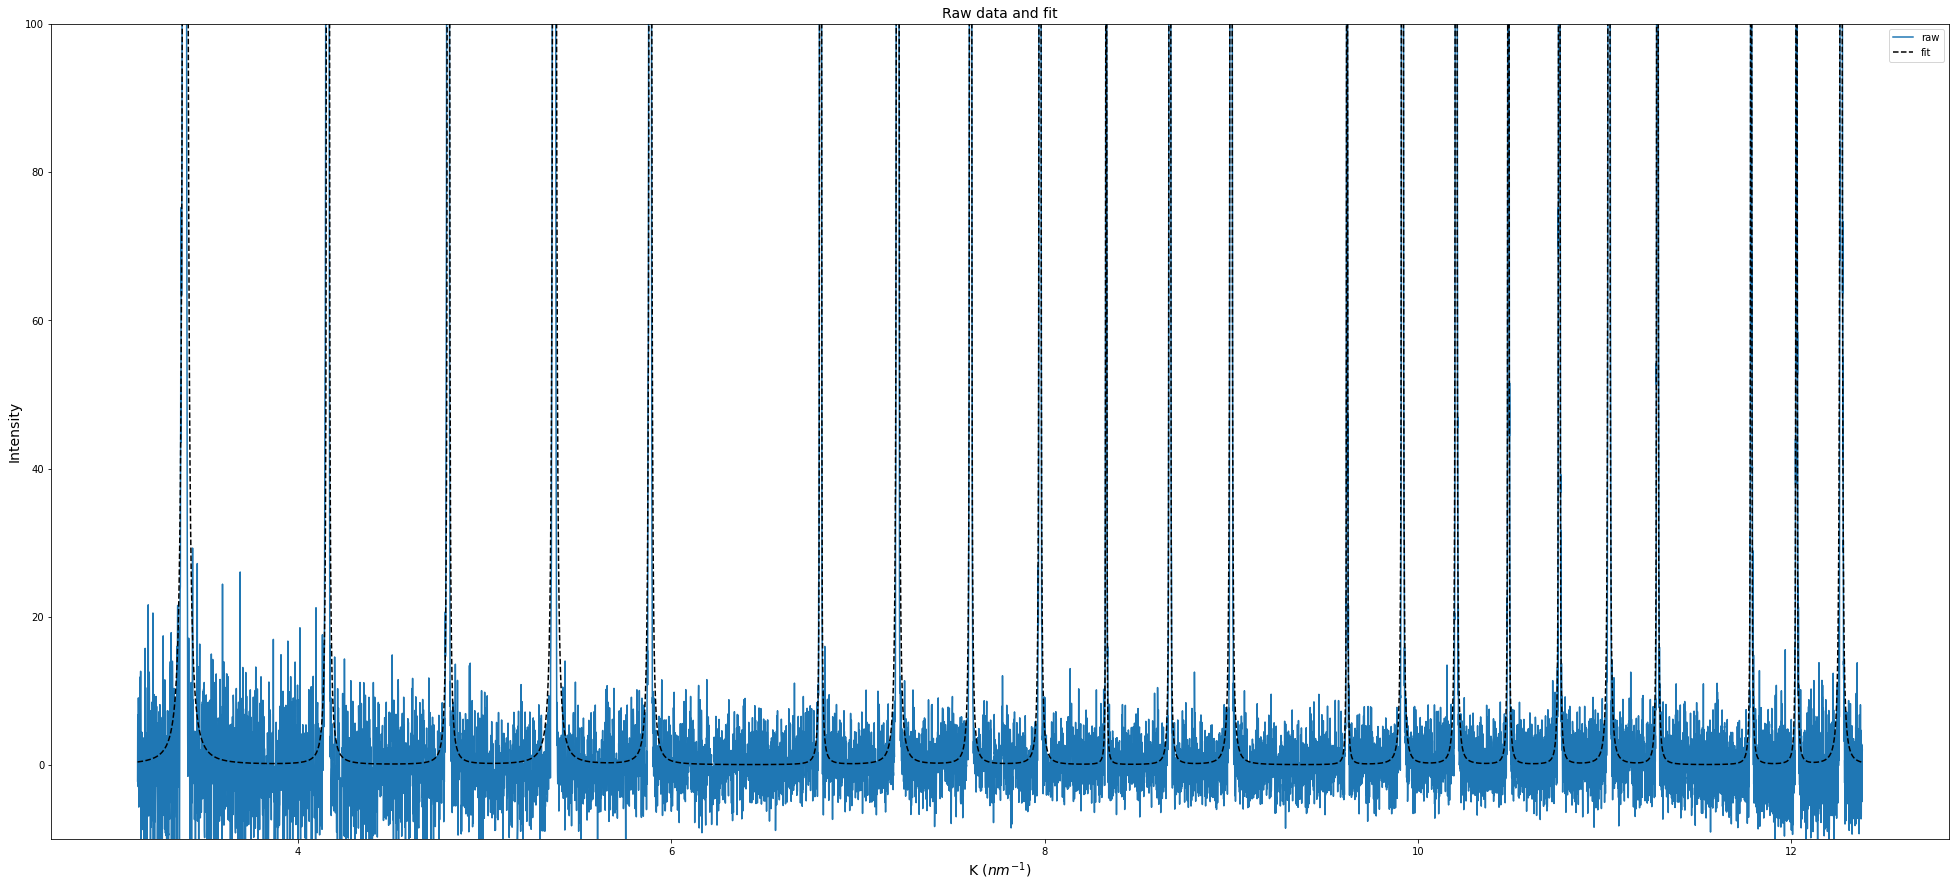

In [90]:
fig, ax = plt.subplots(1,1, figsize=(34, 15))
# Fit each peak independently

models = []
pars = []
prefixes = []
for i, peak in enumerate(actual_peaks):
    print('Peak {0} of {1}      '.format(i+1, len(actual_peaks)), end='\r')
        
    search = 100 + i*10
    searchrange = 10

    elem = np.abs(x_k_nm-peak).argmin()

    xvals = x_k_nm[elem-search:elem+search]
    yvals = y_nobck[elem-search:elem+search]
    
    prefix = 'g'+str(i)+'_'
    prefixes.append(prefix)
    
    mod = PseudoVoigtModel(prefix=prefix)
    #mod = Pearson7Model(prefix=prefix, nan_policy='omit')
    models.append(mod)
    
    par = mod.make_params()

    par[prefix+'center'].set(value=peak, min=peak-0.05, max=peak+0.05)
    par[prefix+'sigma'].set(value=0.01, min=0.001, max=0.1)
    par[prefix+'height'].set(value=(np.max(yvals)-np.min(yvals)), min=2)
    pars.append(par)

models = np.sum(models)
pars = np.sum(pars)
    
init = models.eval(pars, x=x_k_nm)
out = models.fit(y_nobck, pars, x=x_k_nm)


# Plotting    
ax.plot(x_k_nm, y_nobck, label='raw')
ax.plot(x_k_nm, np.sum([out.eval_components(x=x_k_nm)[prefix] for prefix in prefixes], axis=0), 'k--', label='fit')
ax.legend()
ax.set_ylim(-10, 100)
ax.set_title('Raw data and fit', fontsize=14)
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);


In [ ]:
BELOW NOT FINISHED

## Save instrumental folder

In [ ]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
for i, peak in enumerate(peak_pos_k_nm):
    print('Peak {0} of {1}      '.format(i+1, len(peak_pos_k_nm)), end='\r')
    if np.min(x_k_nm) < peak < np.max(x_k_nm):
        
        search = 120 + i*5
        
        elem = np.abs(x_k_nm-peak).argmin()
        xvals = x_k_nm[elem-search:elem+search]

        
        
        
    
        with open(outfolder + '/{0:.2f}'.format(peak), 'w') as outfile:
            np.savetxt(outfile, np.transpose([xvals-x_k+nm[elem],comp_list[i]['g0_']*comp_list[i]['g1_']]), fmt = ('%1.5f'))
        